This Strategy is based on Anzhi Chenm, Zigan Wang and Mengxin Yang, Testing the Applicability of the Technical Trading 
Strategy in the Cryptocurrency Market.

The idea is to using Technical Trading Strategies on cryptocurrency market, mainly BTC/USDT and ETH/USDT pair. EMAC Strategy, RSI Strategy, Bollinger Bands Strategy and MACD Strategy are suggested to formulate a profitable strategy.

The performance of the strategies are evaulated by 2 approaches, the annualized return and the sharpe ratio. 
Also, the performance will be assessed on its profitability over the whole sample and the profitability in In-sample period and Out-of-Sample periods.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

The research paper suggested to use the daily price data of Bitcoin(BTC) and Ethereum(ETH) from 2017-08-17 to 2023-10-31, around 6 years data from yahoo finance.

In [2]:
in_sample_start_date = '2017-08-17'
in_sample_end_date = '2021-12-20'
out_of_sample_start_date = '2021-12-20'
out_of_sample_end_date = '2023-10-31'

In [3]:
btc_df = pd.read_csv('./data/yfinance_BTC.csv')
btc_df = btc_df.set_index('Date')
btc_df.index = pd.to_datetime(btc_df.index)
btc_df_in_sample = btc_df.loc[in_sample_start_date:in_sample_end_date]
btc_df_out_of_sample = btc_df.loc[out_of_sample_start_date:out_of_sample_end_date]
btc_df_full = btc_df.loc[in_sample_start_date:out_of_sample_end_date]
eth_df = pd.read_csv('./data/yfinance_ETH.csv')
eth_df = eth_df.set_index('Date')
eth_df.index = pd.to_datetime(eth_df.index)
eth_df_in_sample = eth_df.loc[in_sample_start_date:in_sample_end_date]
eth_df_out_of_sample = eth_df.loc[out_of_sample_start_date:out_of_sample_end_date]
eth_df_full = eth_df.loc[in_sample_start_date:out_of_sample_end_date]
btc_df_full

,Open,High,Low,close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-08-17 00:00:00+00:00,4384.439941,4484.700195,4243.709961,4331.689941,2553359872,0.0,0.0
2017-08-18 00:00:00+00:00,4324.339844,4370.129883,4015.399902,4160.620117,2941710080,0.0,0.0
2017-08-19 00:00:00+00:00,4137.750000,4243.259766,3970.550049,4193.700195,2975820032,0.0,0.0
2017-08-20 00:00:00+00:00,4189.310059,4196.290039,4069.879883,4087.659912,2109769984,0.0,0.0
2017-08-21 00:00:00+00:00,4090.479980,4109.140137,3988.600098,4001.739990,2800890112,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-27 00:00:00+00:00,34156.500000,34238.210938,33416.886719,33909.800781,16418032871,0.0,0.0
2023-10-28 00:00:00+00:00,33907.722656,34399.390625,33874.804688,34089.574219,10160330825,0.0,0.0
2023-10-29 00:00:00+00:00,34089.371094,34743.261719,33947.566406,34538.480469,11160323986,0.0,0.0


Simulation function to calculate returns

In [4]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

commission = 4/10000 ## 3 bps from cost, 1 bps from slippage

def simulation(performance_df,Type):

    performance_df['close'] = performance_df['close'].astype(float)
    ## return is calculated by log_return
    performance_df['ROC'] = np.log(performance_df['close'] / performance_df['Open'])
    performance_df['pos'] = performance_df['signal'].shift(1)  # position when signal was received (meaning, position is updated on the next row)
    performance_df['trade'] = performance_df['signal'].diff().shift(1)   # while signal reflects the new position, trade reflects the transaction made during close time
    
    performance_df['return'] = ((performance_df['pos'] * performance_df['ROC']+1)*(1-(abs(performance_df['trade'])*commission)))-1
    performance_df['Equity'] = 10000  # Set the initial equity value
    performance_df['Equity'] = performance_df['Equity'].shift(1) * (1 + performance_df['return']).cumprod()
    performance_df['unrealized_pnl'] = performance_df['return'].add(1).groupby((performance_df['pos'] != performance_df['pos'].shift()).cumsum()).cumprod().subtract(1)
    performance_df.loc[performance_df['trade'] != 0, 'realized_pnl'] = performance_df['unrealized_pnl']
    performance_df['cum_return'] = performance_df['return'].add(1).cumprod().sub(1)
    performance_df['cum_realized_pnl'] = performance_df['realized_pnl'].add(1).cumprod().sub(1)
    performance_df['long_return'] = performance_df.loc[performance_df['pos'] > 0, 'return']
    performance_df['short_return'] = performance_df.loc[performance_df['pos'] < 0, 'return']
    performance_df['cum_long_return'] = performance_df['long_return'].add(1).cumprod().sub(1)
    performance_df['cum_short_return'] = performance_df['short_return'].add(1).cumprod().sub(1)

    return performance_df

Strategy 1: EMAC Strategy

In [5]:
## EMAC Strategy
def emac_strategy(price_df, short_window, long_window):
    df = price_df.copy()
    df['signal'] = 0.0
    
    df['long_signal'] = 0.0
    df['short_signal'] = 0.0
    df['short_ema'] = df['close'].ewm(span=short_window, adjust=False).mean()
    df['long_ema'] = df['close'].ewm(span=long_window, adjust=False).mean()
    df['signal'][short_window:] = np.where(df['short_ema'][short_window:] > df['long_ema'][short_window:], 1.0, 0.0)
    df['signal'][short_window:] = np.where(df['short_ema'][short_window:] < df['long_ema'][short_window:], -1.0, df['signal'][short_window:])
    result = simulation(df, 'Futures')
    return result

Strategy 2: RSI Strategy

In [6]:
import pandas_ta as ta
def RSI(price_df, overbought, oversold, length=14):
    df = price_df.copy()
    df['RSI'] = ta.rsi(df['close'], length)
    df['signal'] = 0
    df.loc[df['RSI'] > overbought, 'signal'] = -1
    df.loc[df['RSI'] < oversold, 'signal'] = 1
    result = simulation(df, 'Futures')
    return result

Strategy 3: Bollinger Bands Strategy

In [7]:
def BBand(price_df, length, std):
    df = price_df.copy()
    df['SMA'] = df['close'].rolling(window=length).mean()
    df['BB_upper'] = df['SMA'] + std * df['close'].rolling(window=length).std()
    df['BB_lower'] = df['SMA'] - std * df['close'].rolling(window=length).std()
    df['signal'] = 0
    df.loc[df['close'] > df['BB_upper'], 'signal'] = -1
    df.loc[df['close'] < df['BB_lower'], 'signal'] = 1
    result = simulation(df, 'Futures')
    return result 

Strategy 4: MACD Strategy

In [8]:
def MACD(price_df, short, long, signal_prd):
    df = price_df.copy()
    df['EMA_short'] = df['close'].ewm(span=short, adjust=False).mean()
    df['EMA_long'] = df['close'].ewm(span=long, adjust=False).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['Signal_line'] = df['MACD'].ewm(span=signal_prd, adjust=False).mean()

    # Generate trading signals
    df['signal'] = np.where(df['MACD'] > df['Signal_line'], 1, 0)
    df['signal'] = np.where(df['MACD'] < df['Signal_line'], -1, df['signal'])
    result = simulation(df, 'Futures')
    return result

In [9]:
def annualized_return(returns):
    """Calculate the annualized return"""
    average_return = np.mean(returns)
    return (np.exp(average_return * 252) - 1)

def sharpe_ratio(returns, risk_free_rate=0.00):
    """Calculate the Sharpe ratio"""
    return (np.mean(returns) - risk_free_rate) / np.std(returns) * np.sqrt(365)

def max_drawdown(returns):
    """Calculate the maximum drawdown"""
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

In [10]:
def record_performance_metrics(btc_result, key, result):
    strategy_returns = result['return']
    in_sample_returns = strategy_returns.loc[in_sample_start_date:in_sample_end_date]
    out_of_samplereturns = strategy_returns.loc[out_of_sample_start_date:out_of_sample_end_date]
    btc_result[f'{key}_whole_sample_return_series'] = strategy_returns
    btc_result[f'{key}_whole_sample_annualized_return'] = annualized_return(strategy_returns)
    btc_result[f'{key}_whole_sample_sharpe_ratio'] = sharpe_ratio(strategy_returns)
    btc_result[f'{key}_whole_sample_max_drawdown'] = max_drawdown(strategy_returns)
    btc_result[f'{key}_in_sample_annualized_return'] = annualized_return(in_sample_returns) 
    btc_result[f'{key}_in_sample_sharpe_ratio'] = sharpe_ratio(in_sample_returns)
    btc_result[f'{key}_in_sample_max_drawdown'] = max_drawdown(in_sample_returns)
    btc_result[f'{key}_out_of_sample_annualized_return'] = annualized_return(out_of_samplereturns)
    btc_result[f'{key}_out_of_sample_sharpe_ratio'] = sharpe_ratio(out_of_samplereturns)
    btc_result[f'{key}_out_of_sample_max_drawdown'] = max_drawdown(out_of_samplereturns)

In [11]:
btc_result = {}
for short_window in range(10, 34, 4):
    for long_window in range(35, 59, 4):
        key = f'EMAC_({short_window}, {long_window})'
        result = emac_strategy(btc_df_full, short_window=short_window, long_window=long_window)
        record_performance_metrics(btc_result, key, result)
        print(f'EMAC_{short_window}_{long_window} is done')

for upper in range(70, 94, 4):
    for lower in range(20, 44, 4):
        key = f'RSI_({upper}, {lower})'
        result = RSI(btc_df_full, overbought=upper, oversold=lower)
        record_performance_metrics(btc_result, key, result)
        print(f'RSI_{upper}_{lower} is done')

for length in range(10, 34, 4):
    for std in range(1, 4):
        key = f'BBand_({length}, {std})'
        result = BBand(btc_df_full, length=length, std=std)
        record_performance_metrics(btc_result, key, result)     
        print(f'BBand_{length}_{std} is done')
for short in range(10, 30, 5):
    for long in range(25, 45, 5):
        for signal_prd in range(6, 15, 3):
            key = f'MACD_({short}, {long}, {signal_prd})'
            result = MACD(btc_df_full, short=short, long=long, signal_prd=signal_prd)
            record_performance_metrics(btc_result, key, result)
            print(f'MACD_{short}_{long}_{signal_prd} is done')
eth_result = {}
for short_window in range(10, 34, 4):
    for long_window in range(35, 59, 4):
        key = f'EMAC_({short_window}, {long_window})'
        result = emac_strategy(eth_df_full, short_window=short_window, long_window=long_window)
        record_performance_metrics(eth_result, key, result)
        print(f'EMAC_{short_window}_{long_window} is done')

for upper in range(70, 94, 4):
    for lower in range(20, 44, 4):
        key = f'RSI_({upper}, {lower})'
        result = RSI(eth_df_full, overbought=upper, oversold=lower)
        record_performance_metrics(eth_result, key, result)
        print(f'RSI_{upper}_{lower} is done')

for length in range(10, 34, 4):
    for std in range(1, 4):
        key = f'BBand_({length}, {std})'
        result = BBand(eth_df_full, length=length, std=std)
        record_performance_metrics(eth_result, key, result)     
        print(f'BBand_{length}_{std} is done')

for short in range(10, 30, 5):
    for long in range(25, 45, 5):
        for signal_prd in range(6, 15, 3):
            key = f'MACD_({short}, {long}, {signal_prd})'
            result = MACD(eth_df_full, short=short, long=long, signal_prd=signal_prd)
            record_performance_metrics(eth_result, key, result)
            print(f'MACD_{short}_{long}_{signal_prd} is done')


EMAC_10_35 is done
EMAC_10_39 is done
EMAC_10_43 is done
EMAC_10_47 is done
EMAC_10_51 is done
EMAC_10_55 is done
EMAC_14_35 is done
EMAC_14_39 is done
EMAC_14_43 is done
EMAC_14_47 is done
EMAC_14_51 is done
EMAC_14_55 is done
EMAC_18_35 is done
EMAC_18_39 is done
EMAC_18_43 is done
EMAC_18_47 is done
EMAC_18_51 is done
EMAC_18_55 is done
EMAC_22_35 is done
EMAC_22_39 is done
EMAC_22_43 is done
EMAC_22_47 is done
EMAC_22_51 is done
EMAC_22_55 is done
EMAC_26_35 is done
EMAC_26_39 is done
EMAC_26_43 is done
EMAC_26_47 is done
EMAC_26_51 is done
EMAC_26_55 is done
EMAC_30_35 is done
EMAC_30_39 is done
EMAC_30_43 is done
EMAC_30_47 is done
EMAC_30_51 is done
EMAC_30_55 is done
RSI_70_20 is done
RSI_70_24 is done
RSI_70_28 is done
RSI_70_32 is done
RSI_70_36 is done
RSI_70_40 is done
RSI_74_20 is done
RSI_74_24 is done
RSI_74_28 is done
RSI_74_32 is done
RSI_74_36 is done
RSI_74_40 is done
RSI_78_20 is done
RSI_78_24 is done
RSI_78_28 is done
RSI_78_32 is done
RSI_78_36 is done
RSI_78_40 

We can select the best strategy based on 2 metrics, 1.Annualized Return, 2. Sharpe Ratio
Here, we only use Sharpe Ratio as the criteria for simiplicity

Best EMAC Strategy: Profitability Over the Whole Sample

The EMAC(22,43) was selected based on the best annualized return over the whole sample, the annualized return is 72.5%, with a Sharpe ratio is 1.076 and a maximum drawdown of 60.57%

In [12]:
import pandas as pd

def select_best_strategy(btc_result, strategy_name):
    max_sharpe_ratio = 0
    best_strategy = ''
    for key, value in btc_result.items():
        if key.startswith(strategy_name) and key.endswith('_whole_sample_sharpe_ratio'):
            if value > max_sharpe_ratio:
                max_sharpe_ratio = value
                best_strategy = key
    best_result = {
        'Strategy': [best_strategy.replace("_sharpe_ratio", "")],
        'Annualized Return': [btc_result[best_strategy.replace("sharpe_ratio", "annualized_return")]],
        'Sharpe Ratio': btc_result[best_strategy.replace("sharpe_ratio", "sharpe_ratio")],
        'Max Drawdown': [btc_result[best_strategy.replace("sharpe_ratio", "max_drawdown")]]
    }
    return best_result

# Assuming you have the individual result dictionaries: best_emac, best_rsi, best_bband, best_macd

# Create individual DataFrames
btc_emac = pd.DataFrame(select_best_strategy(btc_result, 'EMAC'))
btc_rsi = pd.DataFrame(select_best_strategy(btc_result, 'RSI'))
btc_bband = pd.DataFrame(select_best_strategy(btc_result, 'BBand'))
btc_macd = pd.DataFrame(select_best_strategy(btc_result, 'MACD'))

# Concatenate the DataFrames into a single DataFrame
best_btc_result = pd.concat([btc_emac, btc_rsi, btc_bband, btc_macd], ignore_index=True)
best_btc_result

,Strategy,Annualized Return,Sharpe Ratio,Max Drawdown
0,"EMAC_(22, 43)_whole_sample",0.725222,1.075633,-0.605772
1,"RSI_(86, 28)_whole_sample",0.076235,0.452575,-0.393144
2,"BBand_(22, 3)_whole_sample",0.025295,0.365246,-0.191395
3,"MACD_(15, 25, 12)_whole_sample",0.743643,1.091709,-0.628047


In [13]:
eth_emac = pd.DataFrame(select_best_strategy(eth_result, 'EMAC'))
eth_rsi = pd.DataFrame(select_best_strategy(eth_result, 'RSI'))
eth_bband = pd.DataFrame(select_best_strategy(eth_result, 'BBand'))
eth_macd = pd.DataFrame(select_best_strategy(eth_result, 'MACD'))

# Concatenate the DataFrames into a single DataFrame
best_eth_result = pd.concat([eth_emac, eth_rsi, eth_bband, eth_macd], ignore_index=True)
best_eth_result

,Strategy,Annualized Return,Sharpe Ratio,Max Drawdown
0,"EMAC_(10, 35)_whole_sample",0.939302,1.039557,-0.799689
1,"RSI_(90, 20)_whole_sample",0.023959,0.285751,-0.229271
2,"BBand_(14, 3)_whole_sample",0.009775,0.172924,-0.093046
3,"MACD_(25, 40, 9)_whole_sample",1.091009,1.157026,-0.676501


In [14]:
import numpy as np
from scipy.stats import norm
## Null Hypothese: The selected strategy is not the best strategy
def individual_test(selected_strategy_returns):
    # Calculate the test statistic
    d_j = np.mean(selected_strategy_returns) / np.std(selected_strategy_returns) * np.sqrt(len(selected_strategy_returns))
    
    # Calculate the p-value
    p_value = 2 * (1 - norm.cdf(np.abs(d_j)))
    
    return p_value

# Bootstrap reality check on annualized return
def reality_check(btc_result, best_original, best_return):
    returns_series = pd.DataFrame()
    for key, value in btc_result.items():
        if key.endswith('_whole_sample_return_series'):
            if best_original in key:
                continue
            else:
                returns_series[key] = value
    returns = returns_series.fillna(0)
    detrended_returns = pd.DataFrame()
    for column in returns.columns:
        detrended_returns[column] = returns[column] - returns[column].mean()
    detrended = [np.array(detrended_returns[col]) for col in detrended_returns.columns]
    n_bootstrap = 1000
    bootstrap_bests = []
    for _ in range(n_bootstrap):
        bootstrap_performances = []
        for s in detrended:
            bootstrapped = np.random.choice(s, size=len(s), replace=True)
            bootstrap_performances.append(annualized_return(bootstrapped))
        bootstrap_bests.append(max(bootstrap_performances))
    # Calculate p-value
    p_value = sum(b > best_return for b in bootstrap_bests) / n_bootstrap

    return p_value

## Generate the p-value from the selected strategy
best_btc_emac_strategy = best_btc_result.loc[0, 'Strategy']
best_btc_rsi_strategy = best_btc_result.loc[1, 'Strategy']
best_btc_bband_strategy = best_btc_result.loc[2, 'Strategy']
best_btc_macd_strategy = best_btc_result.loc[3, 'Strategy']
## do the statistical check for all strategy

print(f'Statistical testing result for BTC')
nominal_p = individual_test(btc_result[f'{best_btc_emac_strategy}_return_series'])
print(f'Best EMAC Strategy nominal p-value: {nominal_p}')
p_value_re = reality_check(btc_result, f'{best_btc_emac_strategy}', best_btc_result.loc[0, 'Annualized Return'])
print(f'Best EMAC Strategy reality check p-value: {p_value_re}')
nominal_p = individual_test(btc_result[f'{best_btc_rsi_strategy}_return_series'])
print(f'Best RSI Strategy nominal p-value: {nominal_p}')
p_value_re = reality_check(btc_result, f'{best_btc_rsi_strategy}', best_btc_result.loc[1, 'Annualized Return'])
print(f'Best RSI Strategy reality check p-value: {p_value_re}')
nominal_p = individual_test(btc_result[f'{best_btc_bband_strategy}_return_series'])
print(f'Best BBand Strategy nominal p-value: {nominal_p}')
p_value_re = reality_check(btc_result, f'{best_btc_bband_strategy}', best_btc_result.loc[2, 'Annualized Return'])
print(f'Best BBand Strategy reality check p-value: {p_value_re}')
nominal_p = individual_test(btc_result[f'{best_btc_macd_strategy}_return_series'])
print(f'Best MACD Strategy nominal p-value: {nominal_p}')
p_value_re = reality_check(btc_result, f'{best_btc_macd_strategy}', best_btc_result.loc[3, 'Annualized Return'])
print(f'Best MACD Strategy reality check p-value: {p_value_re}')

Statistical testing result for BTC
Best EMAC Strategy nominal p-value: 0.007347487607957115
Best EMAC Strategy reality check p-value: 0.257
Best RSI Strategy nominal p-value: 0.25936315451305125
Best RSI Strategy reality check p-value: 1.0
Best BBand Strategy nominal p-value: 0.36268659489757127
Best BBand Strategy reality check p-value: 1.0
Best MACD Strategy nominal p-value: 0.006513715819027155
Best MACD Strategy reality check p-value: 0.249


BTC Result

EMAC Strategy: The reality check p-value of 0.257 indicates that the observed annualized return of the EMAC strategy is not statistically significant at a 5% level.

RSI Strategy: The reality check p-value of 1.0 suggests that the observed annualized return of the RSI strategy is not statistically significant at a 5% level. 
This implies that the strategy's performance may not be reliably different from what would be expected by random chance in the whole sample BTC/USDT analysis.

BBand Strategy: The reality check p-value of 1.0 indicates that the observed annualized return of the BBand strategy is not statistically significant at a 5% level. 
This suggests that the strategy may not offer a reliably different performance compared to random chance in the whole sample BTC/USDT analysis.

MACD Strategy: The reality check p-value of 0.249 indicates that the observed annualized return of the MACD strategy is not statistically significant at a 5% level. 
This implies that the strategy's performance may not be significantly different from what would be expected by random chance in the whole sample BTC/USDT analysis.

In [15]:
import pandas as pd

def get_performance_metrics(btc_result, best_strategy):
    in_sample_strategy = best_strategy.replace("whole_sample", "in_sample")
    out_of_sample_strategy = best_strategy.replace("whole_sample", "out_of_sample")

    in_sample_annualized_return = btc_result[f'{in_sample_strategy}_annualized_return']
    in_sample_sharpe_ratio = btc_result[f'{in_sample_strategy}_sharpe_ratio']
    in_sample_max_drawdown = btc_result[f'{in_sample_strategy}_max_drawdown']

    out_of_sample_annualized_return = btc_result[f'{out_of_sample_strategy}_annualized_return']
    out_of_sample_sharpe_ratio = btc_result[f'{out_of_sample_strategy}_sharpe_ratio']
    out_of_sample_max_drawdown = btc_result[f'{out_of_sample_strategy}_max_drawdown']

    data = {
        'Strategy': [best_strategy.replace("_whole_sample", "")],
        'In-sample Annualized Return': [in_sample_annualized_return],
        'In-sample Sharpe Ratio': [in_sample_sharpe_ratio],
        'In-sample Max Drawdown': [in_sample_max_drawdown],
        'Out-of-sample Annualized Return': [out_of_sample_annualized_return],
        'Out-of-sample Sharpe Ratio': [out_of_sample_sharpe_ratio],
        'Out-of-sample Max Drawdown': [out_of_sample_max_drawdown]
    }
    performance = pd.DataFrame(data)
    return performance

# Assuming you have a list of selected best strategies: selected_strategies

# Create an empty DataFrame to store the performance metrics
all_performance = pd.DataFrame()

# Loop through the selected strategies and get the performance metrics
for i in range(len(best_btc_result)):
    strategy = best_btc_result.loc[i, 'Strategy']
    strategy_performance = get_performance_metrics(btc_result, strategy)
    all_performance = pd.concat([all_performance, strategy_performance], ignore_index=True)

all_performance

,Strategy,In-sample Annualized Return,In-sample Sharpe Ratio,In-sample Max Drawdown,Out-of-sample Annualized Return,Out-of-sample Sharpe Ratio,Out-of-sample Max Drawdown
0,"EMAC_(22, 43)",1.036621,1.291045,-0.605772,0.169967,0.408147,-0.583734
1,"RSI_(86, 28)",0.099298,0.530676,-0.393144,0.024304,0.206165,-0.189025
2,"BBand_(22, 3)",0.046296,0.680820,-0.068588,-0.022001,-0.306589,-0.191395
3,"MACD_(15, 25, 12)",1.243197,1.459316,-0.628047,-0.032032,-0.084645,-0.542877


In [16]:
## get the p-value for ETH
best_eth_emac_strategy = best_eth_result.loc[0, 'Strategy']
best_eth_rsi_strategy = best_eth_result.loc[1, 'Strategy']
best_eth_bband_strategy = best_eth_result.loc[2, 'Strategy']
best_eth_macd_strategy = best_eth_result.loc[3, 'Strategy']

print(f'Statistical testing result for ETH')
nominal_p = individual_test(eth_result[f'{best_eth_emac_strategy}_return_series'])
print(f'Best EMAC Strategy nominal p-value: {nominal_p}')
p_value_re = reality_check(eth_result, f'{best_eth_emac_strategy}', best_eth_result.loc[0, 'Annualized Return'])
print(f'Best EMAC Strategy reality check p-value: {p_value_re}')
nominal_p = individual_test(eth_result[f'{best_eth_rsi_strategy}_return_series'])
print(f'Best RSI Strategy nominal p-value: {nominal_p}')
p_value_re = reality_check(eth_result, f'{best_eth_rsi_strategy}', best_eth_result.loc[1, 'Annualized Return'])
print(f'Best RSI Strategy reality check p-value: {p_value_re}')
nominal_p = individual_test(eth_result[f'{best_eth_bband_strategy}_return_series'])
print(f'Best BBand Strategy nominal p-value: {nominal_p}')
p_value_re = reality_check(eth_result, f'{best_eth_bband_strategy}', best_eth_result.loc[2, 'Annualized Return'])
print(f'Best BBand Strategy reality check p-value: {p_value_re}')
nominal_p = individual_test(eth_result[f'{best_eth_macd_strategy}_return_series'])
print(f'Best MACD Strategy nominal p-value: {nominal_p}')
p_value_re = reality_check(eth_result, f'{best_eth_macd_strategy}', best_eth_result.loc[3, 'Annualized Return'])
print(f'Best MACD Strategy reality check p-value: {p_value_re}')

Statistical testing result for ETH
Best EMAC Strategy nominal p-value: 0.0110122069812153
Best EMAC Strategy reality check p-value: 0.387
Best RSI Strategy nominal p-value: 0.4846622232997837
Best RSI Strategy reality check p-value: 1.0
Best BBand Strategy nominal p-value: 0.6723697041783598
Best BBand Strategy reality check p-value: 1.0
Best MACD Strategy nominal p-value: 0.004660773246631722
Best MACD Strategy reality check p-value: 0.197


ETH Result

EMAC Strategy: The reality check p-value of 0.387 indicates that the observed annualized return of the EMAC strategy is not statistically significant at a 5% level.

RSI Strategy: The reality check p-value of 1.0 suggests that the observed annualized return of the RSI strategy is not statistically significant at a 5% level. 
This implies that the strategy's performance may not be reliably different from what would be expected by random chance in the whole sample ETH/USDT analysis.

BBand Strategy: The reality check p-value of 1.0 indicates that the observed annualized return of the BBand strategy is not statistically significant at a 5% level. 
This suggests that the strategy may not offer a reliably different performance compared to random chance in the whole sample ETH/USDT analysis.

MACD Strategy: The reality check p-value of 0.197 indicates that the observed annualized return of the MACD strategy is not statistically significant at a 5% level. 
This implies that the strategy's performance may not be significantly different from what would be expected by random chance in the whole sample ETH/USDT analysis.

In [17]:
## get the in-sample and out-of-sample performance
# Create an empty DataFrame to store the performance metrics
all_performance_eth = pd.DataFrame()

for i in range(len(best_eth_result)):
    strategy = best_eth_result.loc[i, 'Strategy']
    strategy_performance = get_performance_metrics(eth_result, strategy)
    all_performance_eth = pd.concat([all_performance_eth, strategy_performance], ignore_index=True)
all_performance_eth

,Strategy,In-sample Annualized Return,In-sample Sharpe Ratio,In-sample Max Drawdown,Out-of-sample Annualized Return,Out-of-sample Sharpe Ratio,Out-of-sample Max Drawdown
0,"EMAC_(10, 35)",1.533558,1.340365,-0.681922,0.073848,0.145914,-0.799689
1,"RSI_(90, 20)",0.009824,0.108667,-0.229271,0.055781,0.842996,-0.000400
2,"BBand_(14, 3)",0.015204,0.223196,-0.093046,-0.002102,-0.271174,-0.013804
3,"MACD_(25, 40, 9)",1.765060,1.465384,-0.522752,0.127209,0.245218,-0.676501


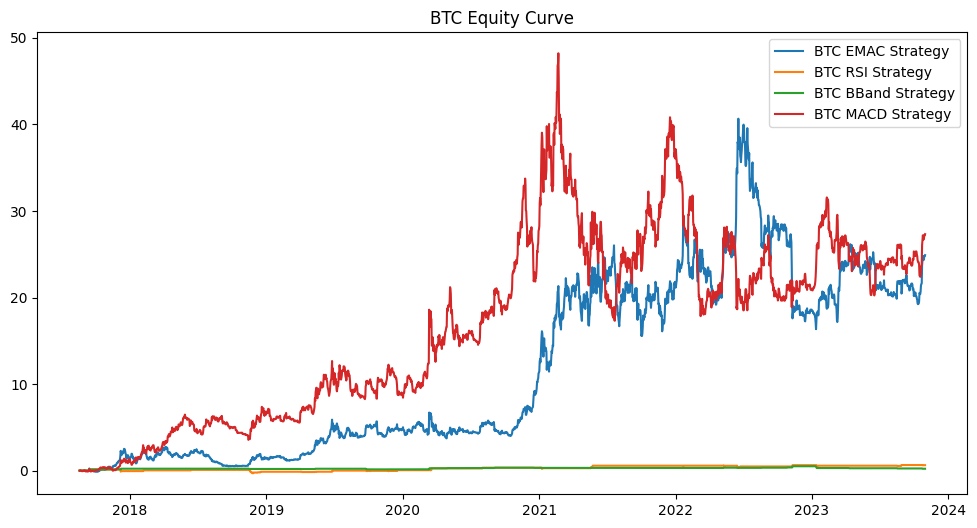

In [22]:
## Plot the equity curve for EMAC Straetgy
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(btc_result[f'{best_btc_emac_strategy}_return_series'].add(1).cumprod().sub(1), label='BTC EMAC Strategy')
plt.plot(btc_result[f'{best_btc_rsi_strategy}_return_series'].add(1).cumprod().sub(1), label='BTC RSI Strategy')
plt.plot(btc_result[f'{best_btc_bband_strategy}_return_series'].add(1).cumprod().sub(1), label='BTC BBand Strategy')
plt.plot(btc_result[f'{best_btc_macd_strategy}_return_series'].add(1).cumprod().sub(1), label='BTC MACD Strategy')

## add the legend, title
plt.legend()
plt.title('BTC Equity Curve')
plt.show()

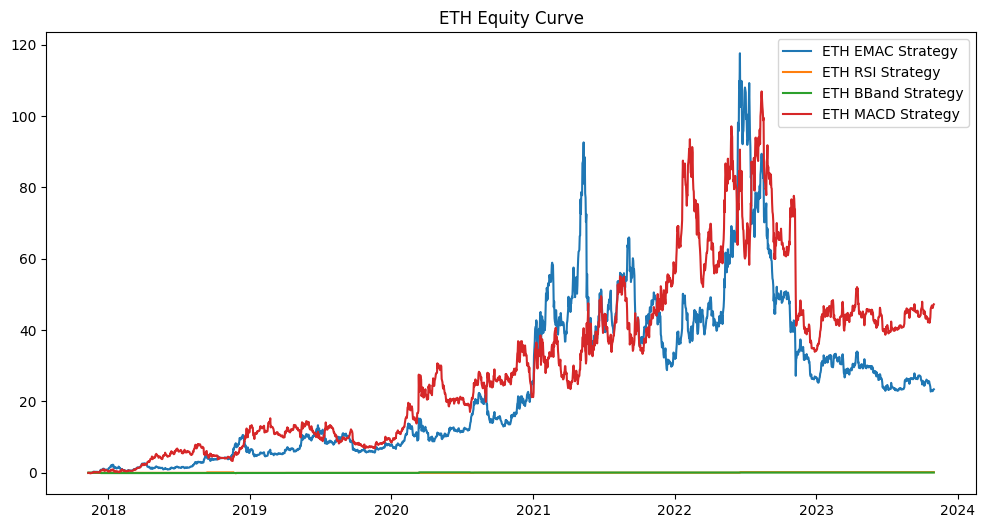

In [23]:
## plot the equity curve for ETH
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(eth_result[f'{best_eth_emac_strategy}_return_series'].add(1).cumprod().sub(1), label='ETH EMAC Strategy')
plt.plot(eth_result[f'{best_eth_rsi_strategy}_return_series'].add(1).cumprod().sub(1), label='ETH RSI Strategy')
plt.plot(eth_result[f'{best_eth_bband_strategy}_return_series'].add(1).cumprod().sub(1), label='ETH BBand Strategy')
plt.plot(eth_result[f'{best_eth_macd_strategy}_return_series'].add(1).cumprod().sub(1), label='ETH MACD Strategy')

## add the legend, title
plt.legend()
plt.title('ETH Equity Curve')
plt.show()

Thoughts and Conclusion:

1. We can see the profitability of the strategy is highly assoicated to its p-value in the reality check.

2. Inconsistency in terms of performance in the in-sample period, and the out-of-sample period. This is undesirable and may implies that the technical trading strategy might be applicable during in-sample period, but as the crypto market grow and more efficient, the performance of technical trading strategy is worsening.

3. Performance in Reversion Strategy is unstaisfactory, this might due to the nature of the cryptocurrency market, where the market increase a lot since 2017. While Momentum strategy can achieve a good annualized return, especially in the in-sample period, where the market doubled or even tripled.

Suggestions:

1. Price data from cryptocurrency exchanges like Binance or Coinbase, should be used for more realistic simulation, instead of the data from yahoo finance

2. Price data starting from 2020-01-01 to 2023-12-31, could be used, since during this period, the market has gone through bull and bear, where we can better test the strategy performance in different market condition.

3. Extend the token universe to other altcoins

